![](../img/330-banner.png)

Lecture 18: Multi-class Classification | Neural Networks | Computer Vision
-------------------

UBC 2022-23 W2

Instructor: Amir Abdi

Office Hours: Mondays 5-6 PM

Anonymous Feedback: https://forms.gle/t21FhAVG8aY2mFs56

## Imports and LO

### Imports

In [59]:
import glob
import copy
import os, sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("../code/.")

from plotting_functions import *


from sklearn import datasets
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

## ❓❓ Questions for you

### iClicker Exercise 19.1 

**iClicker cloud join link: https://join.iclicker.com/EMMJ**

**Select all of the following statements which are TRUE.**

- (A) It's possible to use word2vec embedding representations for text classification instead of bag-of-words representation. 
- (B) The topic model approach we used in the last lecture, Latent Dirichlet Allocation (LDA), is an unsupervised approach. 
- (C) In an LDA topic model, the sum of probabilities of a word being generated from all possible topics (i.e., the sum of probabilities of the word under each topic's word distribution) is always equal to 1.
- (D) In an LDA topic model, a document is a mixture of multiple topics. 
- (E) If I train a topic model on a large collection of news articles with K = 10, I would get 10 topic **labels** (e.g., sports, culture, politics, finance) **as output**. 


Answers:
 - A
 - B
 - C
 - D
 
 E is incorrect becasue we don't get the "labels" out of LDA; we just get K topics, and don't know their labels until we study them closely ourselves.

<br><br>

### Learning objectives

- Apply classifiers to **multi-class classification** algorithms.
- Explain the role of neural networks in machine learning, and the pros/cons of using them.
- Explain why the methods we've learned previously would not be effective on **image data**.
- Apply **pre-trained neural networks** to classification and regression problems.
- Utilize pre-trained networks as feature extractors and combine them with models we've learned previously.

# Multi-class Classification - meta-strategies

- We have seen examples of multi-class classification but we have not explicitly talked about how different models tackle it. 
- ["ImageNet" computer vision competition](http://www.image-net.org/challenges/LSVRC/), for example, has 1000 classes 
- Can we use decision trees or KNNs for image classification on ImageNet? 
- What about decision trees or random forests? 

- Many linear classification models don't extend naturally to the multiclass case. 
- A common technique is to reduce multiclass classication into several instances of binary classification problems. 
- Two kind of **"hacky"** ways to reduce multi-class classification into binary classification:  
    - **one-vs.-rest approach**
    - **one-vs.-one approach**
- In some models, we can do this in **non-hacky**
  - For example, in some models, we can do **one-hot-encoding the target label** and asking the model to predict the probability of the item belonging to each class.

### One vs. Rest (OVR)

- 1v{2,3}, 2v{1,3}, 3v{1,2}
- Learn a binary model for each class which tries to separate that class from all of the other classes.
- If you have $k$ classes, it'll **train $k$ binary** classifiers, one for each class. 
- Trained on imbalanced datasets containing all examples.
- Given a test point, **get scores from all binary classifiers** (e.g., raw scores for logistic regression). 

- The classifier which has the highest score for this class "wins" and that's going to be the prediction for this class. 
- Since we have one binary classifier per class, for each class, we have coefficients per feature and an intercept. 

```{note}
Note that there is also a multinomial logistic regression also called as **the maxent classifier**. This is different than the above multi-class meta strategies.
```

Let's create some synthetic data with two features and three classes. 

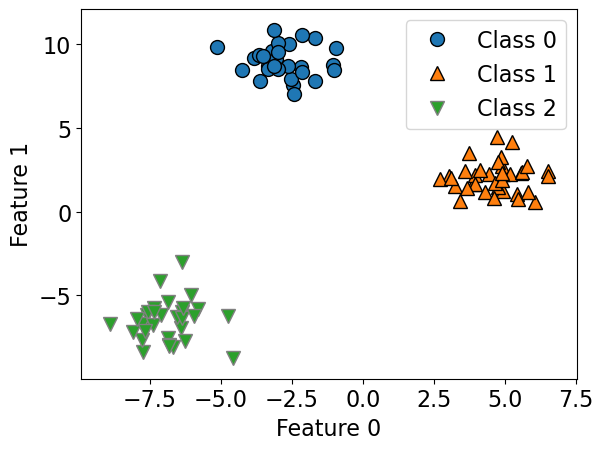

In [2]:
import mglearn
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=3, n_samples=120, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(["Class 0", "Class 1", "Class 2"]);

In [3]:
lr = LogisticRegression(max_iter=2000, multi_class="ovr")
lr.fit(X_train, y_train)
print("Coefficient shape: ", lr.coef_.shape)
print("Intercept shape: ", lr.intercept_.shape)

Coefficient shape:  (3, 2)
Intercept shape:  (3,)


- This learns three binary linear models.
- So we have coefficients for two features for each of these three linear models. 
- Also we have three intercepts, one for each class. 

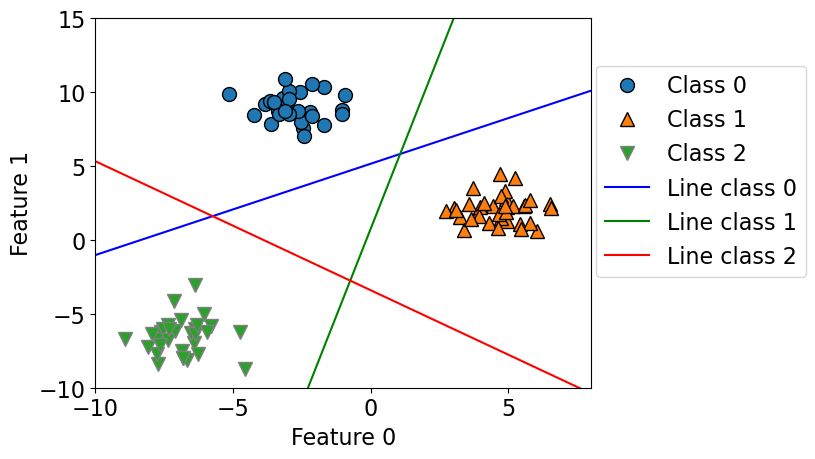

In [4]:
# Function definition in code/plotting_functions.py
from plotting_functions_unsup import plot_multiclass_lr_ovr
plot_multiclass_lr_ovr(lr, X_train, y_train, 3)

**Colors above are mismatched; don't get confused; check the legend**

- How would you classify the following points? 
- The answer is pick the class with the highest value for the classification formula. 

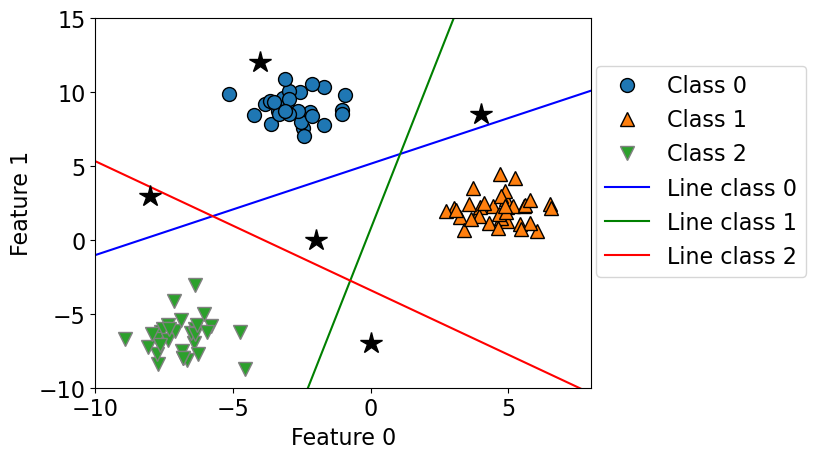

In [5]:
test_points = [[-4.0, 12], [-2, 0.0], [-8, 3.0], [4, 8.5], [0, -7]]            
plot_multiclass_lr_ovr(lr, X_train, y_train, 3, test_points)

**Colors above are mismatched; don't get confused; check the legend**

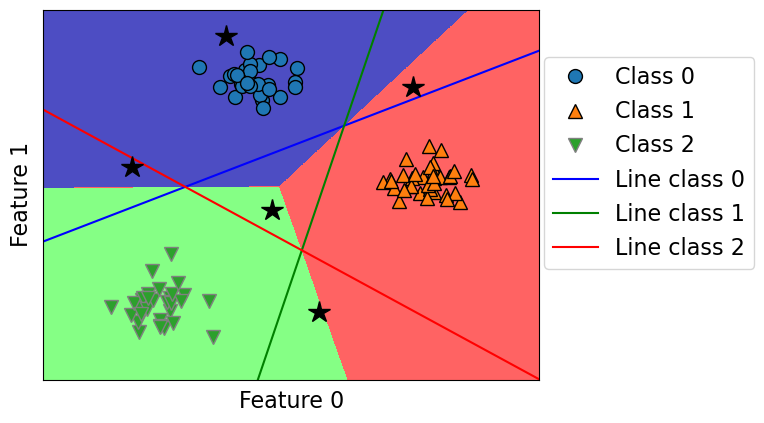

In [6]:
plot_multiclass_lr_ovr(lr, X_train, y_train, 3, test_points, decision_boundary=True)

Let's calculate the raw scores for a test point. 

In [7]:
test_points[4]

[0, -7]

In [8]:
lr.coef_

array([[-0.65123329,  1.0536117 ],
       [ 1.35418019, -0.28647501],
       [-0.63320669, -0.72513556]])

In [9]:
lr.intercept_ 

array([-5.42626721,  0.21616562, -2.46941346])

In [10]:
test_points[4]@lr.coef_.T + lr.intercept_

array([-12.8015491 ,   2.22149069,   2.60653543])

In [11]:
lr.classes_

array([0, 1, 2])

In [12]:
lr.predict_proba([test_points[4]])

array([[1.50344795e-06, 4.92058424e-01, 5.07940073e-01]])

### One Vs. One approach 

- Build a binary model for each pair of classes.
- 1v2, 1v3, 2v3
- Trains $\frac{n \times (n-1)}{2}$ binary classifiers
- Trained on relatively balanced subsets

### One Vs. One prediction

- Apply all of the classifiers on the test example.
- Decide the class with **voting**
  - Hard Vote:
    - Count how often each class was predicted.  
    - Predict the class with **most votes**. 
  - Soft Vote:
    - Check probability of predictions across all classifiers
    - Predict the class with **highest average probability** across predictions. 


### Using OVR and OVO as wrappers

- You can use these strategies as meta-strategies for any binary classifiers. 
    - [`OneVsRestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)
    - [`OneVsOneClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html)

- When do we use  `OneVsRestClassifier` and ``OneVsOneClassifier``?
  - We don't use them much; most of the ML models have native multi-class support. 
  - Good to know them in case you ever need to extend a binary classifier into a MultiClass classifier.

In [13]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

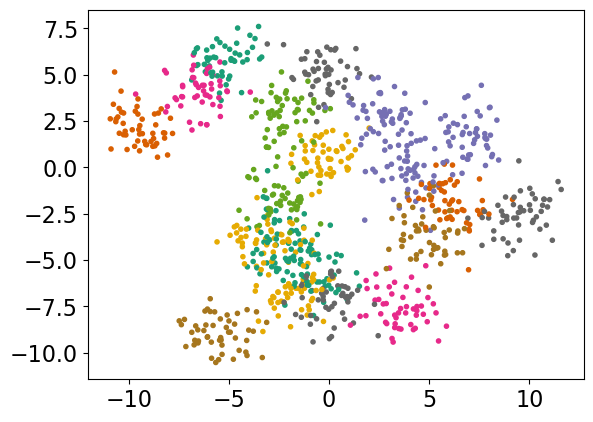

In [14]:
# Let's examine the time taken by OneVsRestClassifier and OneVsOneClassifier

# generate blobs with fixed random generator
X_multi, y_multi = make_blobs(n_samples=1000, centers=20, random_state=300)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi
)

plt.scatter(*X_multi.T, c=y_multi, marker=".", cmap="Dark2");

In [15]:
model = OneVsOneClassifier(LogisticRegression())
%timeit model.fit(X_train_multi, y_train_multi);
print("With OVO wrapper")
print('train score:', model.score(X_train_multi, y_train_multi))
print('test score:', model.score(X_test_multi, y_test_multi))

454 ms ± 24.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
With OVO wrapper
train score: 0.8066666666666666
test score: 0.76


In [16]:
model = OneVsRestClassifier(LogisticRegression())
%timeit model.fit(X_train_multi, y_train_multi);
print("With OVR wrapper")
print('train score:', model.score(X_train_multi, y_train_multi))
print('test score:', model.score(X_test_multi, y_test_multi))

66.2 ms ± 4.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
With OVR wrapper
train score: 0.7293333333333333
test score: 0.712


- As expected OVO takes more time compared to OVR.
- [Here](https://scikit-learn.org/stable/modules/multiclass.html) you will find summary of how `scikit-learn` handles multi-class classification for different classifiers. 

## ❓❓ Questions for you

### iClicker Exercise 19.2 

**iClicker cloud join link: https://join.iclicker.com/EMMJ**

**Select all of the following statements which are TRUE.**

- (A) One-vs.-one strategy uses all the available data when training each binary classifier.
- (B) For a 100-class classification problem, one-vs.-rest multi-class strategy will create 100 binary classifiers. 

Answers:
- B

### LogisticRegression MultiClass Classification

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

- We can see that there's a `multi_class` parameter, that can be set to 
  - `'ovr'`: We just discussed this
  - `'multinomial'`: Not covered here. But you are encouraged to learn about it.
  

<br><br><br><br>

# Introduction to neural networks

- Very popular these days under the name **deep learning**. 
- Neural networks apply a sequence of transformations on your input data.
- They can be viewed a generalization of linear models where we apply a series of transformations. 
- Here is graphical representation of a logistic regression model. 
    - We have 4 features: x[0], x[1], x[2], x[3]

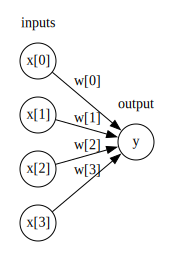

In [17]:
import mglearn

mglearn.plots.plot_logistic_regression_graph()

The above is what we call a **Perceptron**

Important name to remember ;)

<br><br><br><br>

<img src="https://machinelearningknowledge.ai/wp-content/uploads/2019/06/Artificial-Neuron-Working.gif" width="700">

- Below we are adding one "layer" of transformations in between features and the target. 
- We are repeating the the process of computing the weighted sum multiple times.  
- The **hidden units** (e.g., h[1], h[2], ...) represent the intermediate processing steps. 

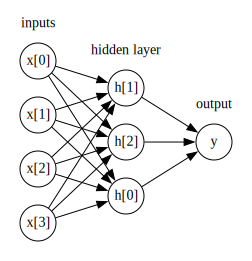

In [18]:
mglearn.plots.plot_single_hidden_layer_graph()

- Now we are adding one more layer of transformations. 

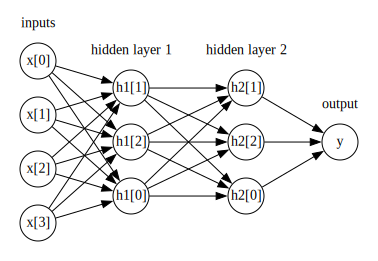

In [19]:
mglearn.plots.plot_two_hidden_layer_graph()

The above is what we call a **Multi Layer Perceptron (MLP)**

<img src="https://machinelearningknowledge.ai/wp-content/uploads/2019/10/Feed-Forward-Neural-Network.gif" width="700">

- Each layer has an input size and an output
- Shape of input and output of each layer is different
  - The signal can get more condensed (smaller vectors) or broadened (larger vectors) as we go deeper into the network 
- The passing of the signal from **inputs** to the final **output** is called a **Feed Forward**

- To make them really powerful compared to the linear models, we apply a **non-linear functio**n to outputs of middle layers.
  - **The power of Neural Networks come from these non-linearities.**

### How is the model trained?

(optional) 

Almost all layers have some "learnable parameters"

Here is how a Supervised model is typically trained:
- At the end of the **Feed Forward** step, the prediction of the network is produced.
- The **Error** (difference) between the prediction and the Target Label is calculated
- The **Error** is **Packpropagated** through the network and all the "learnable parameters" get updated; in more technical terms:
  - The Gradient of the Error with respect to the learnable parameters is calculated using the gradient chain rule
  - Each learnable parameter is updated in the opposite direction of the gradient
- At the end of the **Packpropagated** step, the Learnable Parameters have been updated to reduce the **Error**. 

<img src="https://machinelearningknowledge.ai/wp-content/uploads/2019/10/Backpropagation.gif" width="700">

### Terminology

- Neural network = neural net
- Deep learning = use Neural Networks which are deep (many layers); today, Deep Learning simply means using Neural Networks

### Why neural networks?

- They can learn very complex functions.
  - The fundamental tradeoff is primarily controlled by the **number of layers** and **layer sizes**.
  - More layers / bigger layers --> more complex model.
  - You can generally get a model that will not underfit. 

### Why neural networks?

- The work really well for structured data:
  - 1D sequence, e.g. timeseries, language
  - 2D image
  - 3D image or video
- They've had some incredible successes in the last 10 years.
- Transfer learning (coming later today) is really useful.  

### Why not neural networks?

- Often they require a lot of data.
- They require a lot of compute time, and, to be faster, specialized hardware, including [GPUs](https://en.wikipedia.org/wiki/Graphics_processing_unit) and **TPU (Google) and Tranium (AWS)**
  - TPU stands for **tensor processing unit** and is a designated architecture for deep learning or machine learning applications.
- They have huge numbers of hyperparameters
  - Think of each layer having hyperparameters, plus some overall hyperparameters.
- Slower to train
- They are less interpretable.

### Why not neural networks?

- When you call `fit`, you are not guaranteed to get the optimal.
  - There are now a bunch of hyperparameters specific to `fit`, rather than the model.
  - You never really know if `fit` was successful or not.
  - You never really know if you should have run `fit` for longer.

<br><br><br>
**If you label yourself as a Machine Learning Scientist/Researcher/Engineer, you should learn Deep Learning.**

Yes, you need at least a GPU to do some model training.

- **Good news**: You can use Google Colab for Free and use Google's GPUs: https://colab.research.google.com/notebooks/gpu.ipynb
<br><br><br>

### Deep learning software

- scikit-learn has [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) and [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) but they aren't very flexible.
  - In general you'll want to leave the scikit-learn ecosystem when using neural networks.
  - Fun fact: these classes were contributed to scikit-learn by a UBC graduate student.
- There's been a lot of deep learning software out there.

- The current big players are:

1. [PyTorch](http://pytorch.org)
2. [TensorFlow](https://www.tensorflow.org)

- Both are heavily used in industry.
- If interested, see [comparison of deep learning software](https://en.wikipedia.org/wiki/Comparison_of_deep_learning_software).

<img src="https://www.assemblyai.com/blog/content/images/2021/12/Fraction-of-Papers-Using-PyTorch-vs.-TensorFlow.png">

<img src="https://www.assemblyai.com/blog/content/images/2023/01/percentage_repo_2023.png">

[image src](https://www.assemblyai.com/blog/pytorch-vs-tensorflow-in-2023/)

## Break (3 min)

![](../img/eva-coffee.png)

<br><br><br><br>

## Introduction to computer vision

- [Computer vision](https://en.wikipedia.org/wiki/Computer_vision) refers to understanding images/videos, usually using ML/AI. 
- Computer vision has many tasks of interest:
  - image classification: is this a cat or a dog?
  - object localization: where is the cat in this image?
  - object detection: What are the various objects in the image? 
  - instance segmentation: What are the shapes of these various objects in the image? 
  - and much more...

- In the last decade this field has been dominated by deep learning. 
- We will explore **image classification**.

### Dataset

- For this demonstration I'm using a subset of [Kaggle's Animal Faces dataset](https://www.kaggle.com/datasets/andrewmvd/animal-faces). 
- You are not expected to understand all the code below. But, let's use this opportunity to expose you to some **PyTorch** code early in your career.

In [20]:
# Attribution: [Code from PyTorch docs](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=transfer%20learning)

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms, utils
IMAGE_SIZE = 200

data_transforms_bw = {
    "train": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
            transforms.Grayscale(num_output_channels=1),            
            transforms.ToTensor(),
        ]
    ),
    "valid": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),                        
            transforms.Grayscale(num_output_channels=1),            
            transforms.ToTensor(),
        ]
    ),
}
data_dir = "../data/animal-faces"
image_datasets_bw = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms_bw[x])
    for x in ["train", "valid"]
}
dataloaders_bw = {
    x: torch.utils.data.DataLoader(
        image_datasets_bw[x], batch_size=24, shuffle=True, num_workers=4
    )
    for x in ["train", "valid"]
}
dataset_sizes = {x: len(image_datasets_bw[x]) for x in ["train", "valid"]}
class_names = image_datasets_bw["train"].classes

In [21]:
dataset_sizes

{'train': 14630, 'valid': 1500}

In [22]:
# Get a batch of training data
inputs_bw, classes = next(iter(dataloaders_bw["train"]))

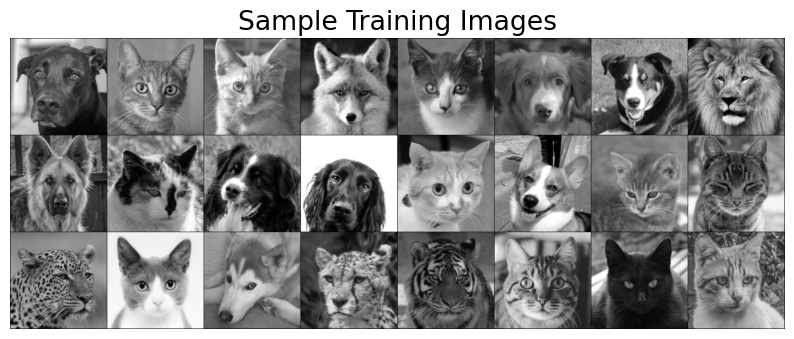

In [23]:
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(inputs_bw, padding=1, normalize=True),(1, 2, 0)));

In [24]:
print(f"Classes: {image_datasets_bw['train'].classes}")
print(f"Class count: {image_datasets_bw['train'].targets.count(0)}, {image_datasets_bw['train'].targets.count(1)}, {image_datasets_bw['train'].targets.count(2)}")
print(f"Samples:", len(image_datasets_bw["train"]))
print(f"First sample: {image_datasets_bw['train'].samples[0]}")

Classes: ['cat', 'dog', 'wild']
Class count: 5153, 4739, 4738
Samples: 14630
First sample: ('../data/animal-faces/train/cat/flickr_cat_000002.jpg', 0)


### Logistic regression with flatten representation of images

- How can we train traditional ML models designed for tabular data on image data?
- Let's flatten the images and trained Logistic regression. 

In [25]:
# This code flattens the images in train and validation sets.
# Again you're not expected to understand all the code.
flatten_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten)
])
train_flatten = torchvision.datasets.ImageFolder(root='../data/animal-faces/train', transform=flatten_transforms)
valid_flatten = torchvision.datasets.ImageFolder(root='../data/animal-faces/valid', transform=flatten_transforms)                                                

In [26]:
train_dataloader = torch.utils.data.DataLoader(train_flatten, batch_size=15000, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_flatten, batch_size=1500, shuffle=True)

In [27]:
flatten_train, y_train = next(iter(train_dataloader))
flatten_valid, y_valid = next(iter(valid_dataloader))

In [28]:
flatten_train.numpy().shape

(14630, 40000)

- We have flattened representation (40_000 columns)
- Let's train a logistic regression on these flattened images.  

In [29]:
lr_flatten_pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=100))
lr_flatten_pipe.fit(flatten_train.numpy(), y_train)

/Users/amirabdi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [30]:
lr_flatten_pipe.score(flatten_train.numpy(), y_train)

0.8801093643198906

In [31]:
lr_flatten_pipe.score(flatten_valid.numpy(), y_valid)

0.6313333333333333

- We are getting not so great on neither Train nor Validation
- We have a lot of data (15k train samples), but, we are still overfitting
  - Fun fact: if you reduce the `max_iter` in `LogisticRegression`, you can stop your model from over-fitting and increase the validation score!
  - **Why?**

<br><br><br><br><br>
**Question:** Why is it a bad idea to **flatten** an image into a 1D array?

This is what we see. 

In [32]:
plt.rcParams["image.cmap"] = "gray"

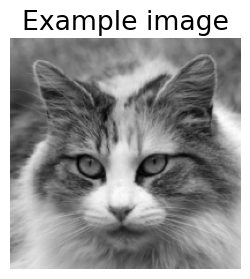

In [33]:
plt.figure(figsize=(3, 3)); plt.axis("off"); plt.title("Example image")
plt.imshow(flatten_train[4].reshape(200,200));

- This is what the computer sees:

In [34]:
flatten_train[4].numpy()

array([0.5019608 , 0.5019608 , 0.4745098 , ..., 0.6745098 , 0.69803923,
       0.7058824 ], dtype=float32)

- Hard to classify this!
- [Convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs) can take in images without flattening them. 

<br><br><br><br><br>
**(Optional) CNN**

Here, we will have a very basic CNN model. I can't cover the details, but, I encourage you to read through the code of this model.

**I'm training this model on CPU, so, it takes about 30-60 mintues.** 

In [35]:
import torch.nn as nn

class MyCNNModule(nn.Module):
    def __init__(self):
        super(MyCNNModule, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=40000, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=3)        
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 40000)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

**Note:** We don't have to convert to GrayScale. I'm only doing this for results to be comparable with the previous experiment

In [36]:
import torch.optim as optim

# Instantiate the network
net = MyCNNModule()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Use the same Train and Valid data loader we had before with a "small" batch size
image_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

train = torchvision.datasets.ImageFolder(root='../data/animal-faces/train', transform=image_transforms)
valid = torchvision.datasets.ImageFolder(root='../data/animal-faces/valid', transform=image_transforms)                                                

train_dataloader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=100, shuffle=True)

# Train the network
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Feed Forward + backward (back propagation) + optimize (updating weights)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

In [37]:
def score_model(net, validloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d validation images: %d %%' % (len(validloader)*validloader.batch_size, 100 * correct / total))


In [38]:
score_model(net, valid_dataloader)

Accuracy of the network on the 1500 validation images: 95 %


The model above was trained using **Stochatic Gradient Descent**
- Stochastic: we trained iteratively on small mini-batches of data
- Gradient Descent: **weights (learnable parameters)** are updated at every iteration towards the opposite direction of the **gradient** of loss (to **reduce (descent)** the loss (error) )

<br><br><br><br>

## Transfer learning

**Transfer Learning**: **transfer**  a learned representation from a **domain** and apply it to another **domain**

- A common practice is to download a pre-trained model and **fine tune** it for your task.   
- This is called **transfer learning**. 
- Transfer learning is one of the most common techniques used in the context of computer vision and natural language processing.

<br><br><br><br>
In the last lecture we used pre-trained embeddings to create text representations.     
We didn't train any models.  
**Q: Was that Transfer Learning?**
- Yes

<br><br><br><br>

- There are many deep learning architectures out there that have been very successful across a wide range of problem, e.g.: AlexNet, VGG, ResNet, Inception, MobileNet, etc.
- Many of these are trained on famous datasets such as ImageNet (which contains 1.2 million labelled images with 1000 categories)

### ImageNet

- [ImageNet](http://www.image-net.org/) is an image dataset that became a very popular benchmark in the field ~10 years ago. 
    - There are 14 million images and 1000 classes.
    - Here are some example classes. 
    - [Wikipedia article](https://en.wikipedia.org/wiki/ImageNet) on ImageNet


In [39]:
with open("../data/imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]
classes[100:110]

['black swan, Cygnus atratus',
 'tusker',
 'echidna, spiny anteater, anteater',
 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 'wallaby, brush kangaroo',
 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 'wombat',
 'jellyfish',
 'sea anemone, anemone',
 'brain coral']

- The idea of transfer learning is instead of developing a machine learning model from scratch, you use these available pre-trained models for your tasks either directly or by fine tuning them. 
- There are three common ways to use transfer learning in computer vision 
    1. Using pre-trained models out-of-the-box (**no training**)
    2. Using pre-trained models as feature extractor and **training your own model with these features**
    2. Starting with weights of pre-trained models and **fine-tuning the weights** for your task. 
- We will explore the first two approaches.     

<br><br>

### Using pre-trained models out-of-the-box 

- **VGG16 Model** which is trained on the **ImageNet** dataset. 
- We preprocess the given image. 
- We get prediction from this pre-trained model on a given image along with prediction probabilities.  
- For a given image, this model will spit out one of the 1000 classes from ImageNet. 

<img src="https://cezannec.github.io/assets/cnn_intro/CNN_ex.png" width="700">

Source: https://cezannec.github.io/Convolutional_Neural_Networks/

In [40]:
def classify_image(img, topn = 4):
    clf = vgg16(weights='VGG16_Weights.DEFAULT') # initialize the classifier with VGG16 weights
    preprocess = transforms.Compose([
                 transforms.Resize(299),
                 transforms.CenterCrop(299),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225]),])

    with open('../data/imagenet_classes.txt') as f:
        classes = [line.strip() for line in f.readlines()]
    
    img_t = preprocess(img)
    batch_t = torch.unsqueeze(img_t, 0)
    clf.eval()
    output = clf(batch_t)
    _, indices = torch.sort(output, descending=True)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    d = {'Class': [classes[idx] for idx in indices[0][:topn]], 
         'Probability score': [np.round(probabilities[0, idx].item(),3) for idx in indices[0][:topn]]}
    df = pd.DataFrame(d, columns = ['Class','Probability score'])
    return df

In [41]:
import torch
from PIL import Image
from torchvision import transforms
from torchvision.models import vgg16

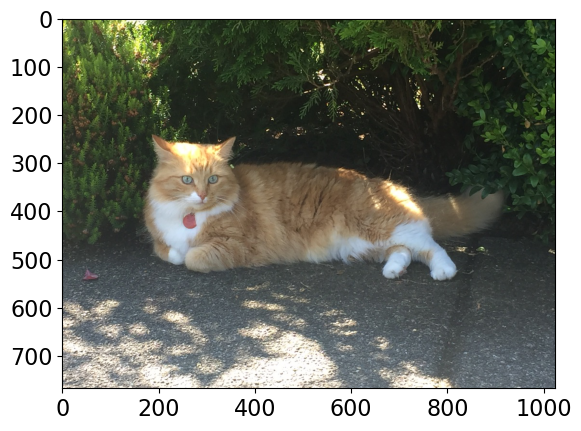

                         Class  Probability score
                     tiger cat              0.357
              tabby, tabby cat              0.207
               lynx, catamount              0.049
Pembroke, Pembroke Welsh corgi              0.046
--------------------------------------------------------------


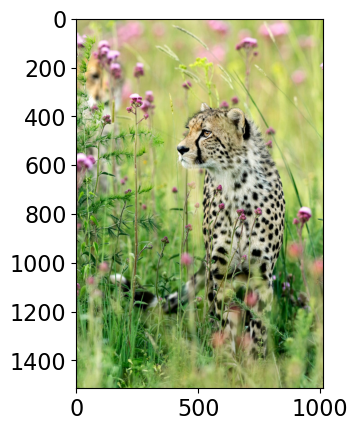

                                     Class  Probability score
         cheetah, chetah, Acinonyx jubatus              0.982
                  leopard, Panthera pardus              0.012
jaguar, panther, Panthera onca, Felis onca              0.004
       snow leopard, ounce, Panthera uncia              0.001
--------------------------------------------------------------


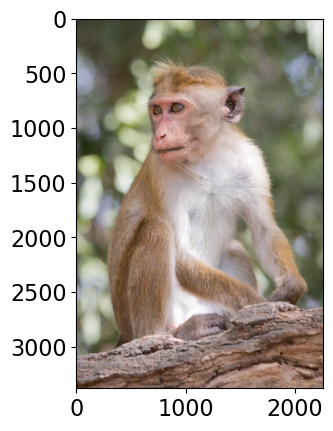

                                   Class  Probability score
                                 macaque              0.714
patas, hussar monkey, Erythrocebus patas              0.122
      proboscis monkey, Nasalis larvatus              0.098
                   guenon, guenon monkey              0.017
--------------------------------------------------------------


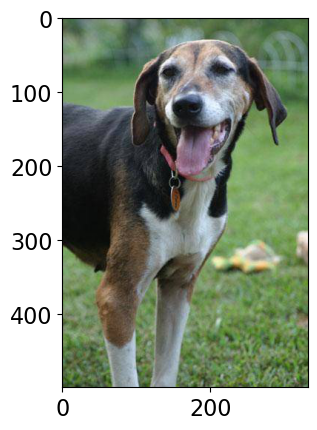

                        Class  Probability score
Walker hound, Walker foxhound              0.577
                  EntleBucher              0.089
             English foxhound              0.086
                       beagle              0.063
--------------------------------------------------------------


In [42]:
# Predict labels with associated probabilities for unseen images
images = glob.glob("../data/test_images/*.*")
for image in images:
    img = Image.open(image)
    img.load()
    plt.imshow(img)
    plt.show()
    df = classify_image(img)
    print(df.to_string(index=False))
    print("--------------------------------------------------------------")

- We got these predictions without "doing the ML ourselves".
- We are using **pre-trained** `vgg16` model which is available in `torchvision`.
- `torchvision` has many such pre-trained models available that have been very successful across a wide range of tasks: AlexNet, VGG, ResNet, Inception, MobileNet, etc.
- Many of these models have been pre-trained on famous datasets like **ImageNet**. 
- So if we use them out-of-the-box, they will give us one of the ImageNet classes as classification. 

<br><br><br><br><br><br>

**Q: Can this model classify images beyond the classes that it was trained on?**

A: Yes, with transfer learning

In [43]:
classes[:50]

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus',
 'brambling, Fringilla montifringilla',
 'goldfinch, Carduelis carduelis',
 'house finch, linnet, Carpodacus mexicanus',
 'junco, snowbird',
 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 'robin, American robin, Turdus migratorius',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel, dipper',
 'kite',
 'bald eagle, American eagle, Haliaeetus leucocephalus',
 'vulture',
 'great grey owl, great gray owl, Strix nebulosa',
 'European fire salamander, Salamandra salamandra',
 'common newt, Triturus vulgaris',
 'eft',
 'spotted salamander, Ambystoma maculatum',
 'axolotl, mud puppy, Ambystoma mexicanum',
 'bullfrog, Rana catesbeiana',
 'tree frog, tree-f

<br><br>

## Using pre-trained models as feature extractor

- Let's use pre-trained models to **extract features**.
- We will pass our specific data through a pre-trained network to get a feature vector for each example in the data. 
- The feature vector is usually extracted from the **last layer**, before the classification layer from the pre-trained network. 
- You can think of each layer a transformer applying some transformations on the input received to that later. 

- Once we extract these feature vectors for all images in our training data, we can train a machine learning classifier such as logistic regression or random forest. 
- This classifier will be trained on our classes using feature representations extracted from the pre-trained models.  
- Let's try this out. 
- It's better to train such models with GPU. Since our dataset is quite small, we won't have problems running it on a CPU. 

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cpu


### Reading the data

- Let's read the data. Before we just used 1 colour channel because we wanted to flatten the representation.
- Here, I'm using all three colour channels. 
- Let's read and prepare the data. (You are not expected to understand this code.)

In [45]:
# Attribution: [Code from PyTorch docs](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=transfer%20learning)

IMAGE_SIZE = 200
BATCH_SIZE = 64

data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),
            # transforms.RandomHorizontalFlip(),
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),     
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),            
        ]
    ),
    "valid": transforms.Compose(
        [
            # transforms.Resize(256),
            # transforms.CenterCrop(224),
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),                        
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),                        
        ]
    ),
}
data_dir = "../data/animal-faces"
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "valid"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4
    )
    for x in ["train", "valid"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "valid"]}
class_names = image_datasets["train"].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [46]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

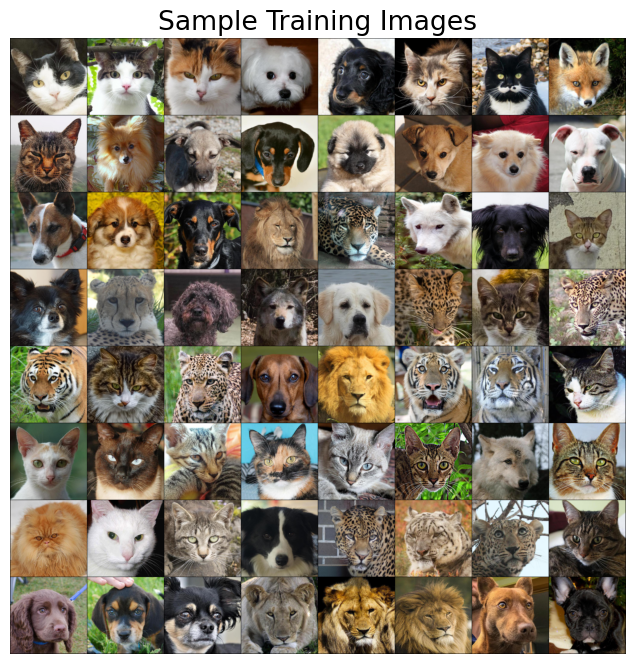

In [47]:
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(inputs, padding=1, normalize=True),(1, 2, 0)));

In [48]:
print(f"Classes: {image_datasets['train'].classes}")
print(f"Class count: {image_datasets['train'].targets.count(0)}, {image_datasets['train'].targets.count(1)}, {image_datasets['train'].targets.count(2)}")
print(f"Samples:", len(image_datasets["train"]))
print(f"First sample: {image_datasets['train'].samples[0]}")

Classes: ['cat', 'dog', 'wild']
Class count: 5153, 4739, 4738
Samples: 14630
First sample: ('../data/animal-faces/train/cat/flickr_cat_000002.jpg', 0)


- Now for each image in our dataset, we'll **extract a feature vector from a pre-trained model called densenet121**, which is trained on the **ImageNet dataset**.  

In [49]:
def get_features(model, train_loader, valid_loader):
    """Extract output of squeezenet model"""
    with torch.no_grad():  # turn off computational graph stuff
        Z_train = torch.empty((0, 1024))  # Initialize empty tensors
        y_train = torch.empty((0))
        Z_valid = torch.empty((0, 1024))
        y_valid = torch.empty((0))
        for X, y in train_loader:
            Z_train = torch.cat((Z_train, model(X)), dim=0)
            y_train = torch.cat((y_train, y))
        for X, y in valid_loader:
            Z_valid = torch.cat((Z_valid, model(X)), dim=0)
            y_valid = torch.cat((y_valid, y))
    return Z_train.detach(), y_train.detach(), Z_valid.detach(), y_valid.detach()

In [50]:
densenet = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")
densenet.classifier = nn.Identity()  # remove that last "classification" layer

In [51]:
Z_train, y_train, Z_valid, y_valid = get_features(
    densenet, dataloaders["train"], dataloaders["valid"]
)

Now we have extracted feature vectors for all examples. What's the shape of these features?

In [52]:
Z_train.shape

torch.Size([14630, 1024])

**The size of each feature vector is 1024 because the size of the last layer in densenet architecture is 1024.**

In [53]:
print(densenet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*SsphOqMwglCVGDWB-jdT5Q.png" width="700">

Source: https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a

Let's examine the feature vectors. 

In [54]:
pd.DataFrame(Z_train).head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.000407,0.006012,0.002133,0.002080,0.230984,0.265679,0.000616,0.003537,0.210490,0.000500,...,0.148545,2.782455,6.175449,1.094194,1.149232,0.502459,2.729192,0.315228,4.382116,0.376200
1,0.000453,0.002166,0.003046,0.000583,0.179222,0.158280,0.000585,0.002772,0.249748,0.000267,...,1.604190,0.255511,3.332658,0.446415,0.476882,0.044830,0.314062,0.153836,6.463080,0.573525
2,0.000139,0.012205,0.002390,0.002848,0.174457,0.360244,0.000249,0.003908,0.463119,0.000397,...,1.408592,2.174608,1.407394,3.203079,0.036970,0.389580,0.054970,0.002782,0.385419,5.428979
3,0.000273,0.002564,0.001956,0.003146,0.073310,0.347257,0.001037,0.003594,0.451506,0.000273,...,1.016114,0.244171,0.134267,0.032889,0.612839,0.622006,1.016543,2.451181,0.358566,1.723449
4,0.000198,0.000718,0.004006,0.002374,0.087944,0.516807,0.000539,0.004123,0.148468,0.000259,...,0.786816,0.344964,0.771820,3.031203,2.293649,2.965133,0.390409,1.710024,0.042623,1.521046


- The features are hard to interpret but they have some important information about the images which can be useful for classification.  
- Let's try out logistic regression on these extracted features. 

In [55]:
Z_train.shape

torch.Size([14630, 1024])

In [56]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000))
pipe.fit(Z_train, y_train)
pipe.score(Z_train, y_train)

1.0

In [57]:
Z_valid.shape

torch.Size([1500, 1024])

In [58]:
pipe.score(Z_valid, y_valid)

0.9953333333333333

**That's how you get great results re-using the representation (features) extracted from a HUGE Densenet Model without triaing it yourself.**


The model you train (here, `LogisticRegression`) can classify new classes which were not present in theb original dataset.

<br><br>

## Random cool stuff

- [A nice video](https://www.youtube.com/watch?v=oGvHtpJMO3M) which gives a high-level introduction to computer vision.
- Style transfer: given a "content image" and a "style image", create a new image with the content of one and the style of the other.
  - Here is the [original paper from 2015](https://arxiv.org/pdf/1508.06576.pdf), see Figure 2.
  - Here are more in [this 2016 paper](https://arxiv.org/pdf/1601.04589.pdf); see, e.g. Figures 1 and 7.
  - This has been done for video as well; see [this video from 2016](https://www.youtube.com/watch?v=Khuj4ASldmU).
- [Image captioning](https://cs.stanford.edu/people/karpathy/sfmltalk.pdf): Transfer learning with NLP and vision 
- Colourization: see [this 2016 project](http://iizuka.cs.tsukuba.ac.jp/projects/colorization/en/).
- [Inception Neural Network](https://arxiv.org/pdf/1409.4842.pdf)
- Inceptionism: let the neural network "make things up"
  - [2015 article](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
  - "Deep dream" [video from 2015](https://www.youtube.com/watch?v=dbQh1I_uvjo).


## Summary

- Multi-class classification refers to classification with >2 classes.
  - Most sklearn classifiers work out of the box.
  - With `LogisticRegression` the situation with the coefficients is a bit funky, we get 1 coefficient per feature per class. 
- Flattening images throws away a lot of useful information (sort of like one-hot encoding on ordinal variable!).
- Neural networks are a flexible class of models.
  - They generally require leaving the sklearn ecosystem to tensorflow or pytorch.
  - They are particular powerful for structured input like images, videos, audio, etc.
- The good news is we can use pre-trained neural networks.
  - This saves us a huge amount of time/cost/effort/resources.
  - We can use these pre-trained networks directly or use them as feature transformers. 
- My general recommendation: don't use deep learning unless there is good reason to.